In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F 

import utils.tavr_torch as tavr_torch
from utils.tavr_torch import TAVR_3_Frame, TAVR_1_Frame, TAVR_Sequence, tavr_dataloader
from utils.visualization import display_grid, z_stretch, visualize_frame, set_figsize, get_central_slices
from utils.loss_functions import batch_l2_loss, batch_mse_loss
from utils.run_model import train, test
from Models.basic_models import average_model, two_layer_basic


set_figsize(20, 15)

Training directory found, 36 series
Validation directory found, 6 series
Testing directory found, 10 series


In [2]:
USE_GPU = True
dtype = torch.float32 # we will be using float throughout this tutorial
if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print('using device:', device)

validation = TAVR_3_Frame("__valid")
val_loader = tavr_dataloader(validation, batch_size=4, shuffle=True, num_workers=2)
training = TAVR_3_Frame("__train")
train_loader = tavr_dataloader(training, batch_size=8, shuffle=True, num_workers=2)

ave_model = average_model()
model = two_layer_basic()
loss_fn = batch_mse_loss()

using device: cpu


In [3]:
learning_rate = 1e-9
momentum = 0.90
reg = 1e-7

optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=reg, nesterov=True)

In [4]:
train(model, optimizer, train_loader, val_loader, loss_fn, device, 
         epochs=3, print_every=30, print_level=3, lr_decay=0.8)


****Epoch 0 Iteration 0, loss = 2867194.0000
Validation loss 1855314.7500 over 81 frames
conv_a1.weight,   	norm: 4.0547e+00, 	update norm: 2.0319e-02 	Update/norm: 5.0113e-03
conv_a1.bias,   	norm: 3.5418e-01, 	update norm: 3.6393e-06 	Update/norm: 1.0275e-05
conv_b1.weight,   	norm: 4.4036e+00, 	update norm: 2.2452e-02 	Update/norm: 5.0986e-03
conv_b1.bias,   	norm: 3.1259e-01, 	update norm: 3.9947e-06 	Update/norm: 1.2779e-05
final.weight,   	norm: 1.3378e+00, 	update norm: 2.3918e-02 	Update/norm: 1.7878e-02
final.bias,   	norm: 1.7159e-01, 	update norm: 5.7071e-06 	Update/norm: 3.3260e-05

Iter 0... ... ... 
Iter 10... ... ... 
Iter 20... ... ... 
Iteration 30, loss = 30161.8516
Validation loss 24936.6250 over 81 frames
conv_a1.weight,   	norm: 4.0332e+00, 	update norm: 2.9643e-03 	Update/norm: 7.3497e-04
conv_a1.bias,   	norm: 3.5416e-01, 	update norm: 6.0115e-07 	Update/norm: 1.6974e-06
conv_b1.weight,   	norm: 4.4112e+00, 	update norm: 2.9510e-03 	Update/norm: 6.6898e-04
conv_

In [ ]:
# INCREASE the learning rate, stop lr decay, train 3 more epochs

optimizer.param_groups[0]['lr'] = 1e-8
train(model, optimizer, train_loader, val_loader, loss_fn, device, 
         epochs=3, print_every=30, print_level=3)


****Epoch 0 Iteration 0, loss = 12612.5488
Validation loss 14005.6084 over 81 frames
conv_a1.weight,   	norm: 4.0280e+00, 	update norm: 2.2825e-03 	Update/norm: 5.6666e-04
conv_a1.bias,   	norm: 3.5416e-01, 	update norm: 6.5345e-07 	Update/norm: 1.8451e-06
conv_b1.weight,   	norm: 4.4067e+00, 	update norm: 2.9340e-03 	Update/norm: 6.6579e-04
conv_b1.bias,   	norm: 3.1260e-01, 	update norm: 6.6998e-07 	Update/norm: 2.1433e-06
final.weight,   	norm: 1.2425e+00, 	update norm: 4.8132e-03 	Update/norm: 3.8739e-03
final.bias,   	norm: 1.7152e-01, 	update norm: 1.1921e-06 	Update/norm: 6.9501e-06

Iter 0... ... ... 
Iter 10... ... ... 
Iter 20... ... ... 
Iteration 30, loss = 8148.6157
Validation loss 7678.6895 over 81 frames
conv_a1.weight,   	norm: 4.0238e+00, 	update norm: 1.3501e-03 	Update/norm: 3.3554e-04
conv_a1.bias,   	norm: 3.5415e-01, 	update norm: 3.2476e-07 	Update/norm: 9.1702e-07
conv_b1.weight,   	norm: 4.4014e+00, 	update norm: 1.9017e-03 	Update/norm: 4.3207e-04
conv_b1.bia

Validation loss 14361.8115 over 81 frames
Validation loss 1427.3856 over 81 frames


/home/shared/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


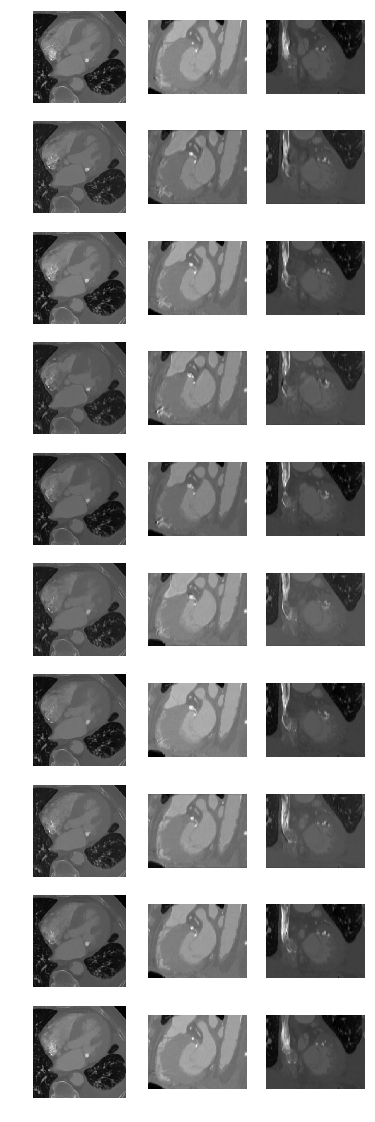

In [5]:
# One last test + visualize results on 1 validation sequence
val_seq = TAVR_Sequence("__valid")
test(model, val_loader, loss_fn, device)
test(ave_model, val_loader, loss_fn, device)

with torch.no_grad():
    model.eval()
    ave_frames = [val_seq[0][0]]
    for i in range(2,9,2):
        ave_frame = model((val_seq[0][i-2][None,:], val_seq[0][i][None,:]))
        ave_frames += [ave_frame[0][0],  val_seq[0][i]]
    ave_frames += [val_seq[0][9]]
    ave_frames_slices = []
    for f in ave_frames:
        ave_frames_slices += get_central_slices(f)
    set_figsize(6,20)
    display_grid(10, 3, ave_frames_slices)